# BreizhCrops Evaluation

In [18]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL, LABELS_NAMES, SELECTED_BANDS
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from earlyrnn import EarlyRNN
import torch
import os
import pandas as pd
from datetime import datetime
import numpy as np
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, recall_score, precision_score

import datetime
import seaborn

import os
import pandas as pd
from datetime import datetime
import numpy as np

import datetime
import seaborn
import datetime
import breizhcrops as bzh
import matplotlib.pyplot as plt

from data_exploration import plot_label_distribution_datasets
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

ImportError: cannot import name 'SELECTED_BANDS' from 'data' (c:\Users\anyam\Desktop\Master thesis\Code\elects\EDA\..\data\__init__.py)

## Initialize and download dataset

In [2]:
data_root = "../elects_data"
valid_ds = BreizhCrops(root=data_root,partition="valid", sequencelength=150, year=2017, return_id = True)
train_ds = BreizhCrops(root=data_root,partition="train", sequencelength=150, year=2017, return_id = True)
test_ds = BreizhCrops(root=data_root,partition="eval", sequencelength=150, year=2017, return_id = True)
classes = test_ds.ds.classname
print(classes)

2493572704 2493572704


loading data into RAM:   0%|          | 0/166391 [00:00<?, ?it/s]

loading data into RAM: 100%|██████████| 166391/166391 [01:13<00:00, 2262.31it/s]


2559635960 2559635960


loading data into RAM: 100%|██████████| 178613/178613 [01:15<00:00, 2355.97it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 140645/140645 [01:01<00:00, 2302.37it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:54<00:00, 2249.14it/s]

['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


What is `test_ds`: 

In [37]:
def ndvi(X):
    BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
            'B8A', 'B9']
    red = X[BANDS.index("B4")]
    nir = X[BANDS.index("B8A")]
    return (nir-red)/(nir+red)

def plot_NDVI(X, fig, ax):
    NDVI_X = ndvi(X)
    ax.plot(NDVI_X, label="NDVI")
    ax.legend()
    ax.set_title("NDVI")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.set_xticks(np.arange(0, len(NDVI_X), 20))
    ax.legend()
    ax.grid()
    return fig, ax


X.shape: torch.Size([150, 13])
y.shape: torch.Size([150])
test_ds.ds.level: L1C
len(test_ds): 122614
year: 2017
index:              id CODE_CULTU                   path     meanCLD  sequencelength  \
idx                                                                             
0       6017564        PTR  csv/frh04/6017564.csv  780.075742             102   
6       6054675        PTR  csv/frh04/6054675.csv  731.428571              49   
7       6018665        PTR  csv/frh04/6018665.csv  710.530612              49   
8       6019318        PTR  csv/frh04/6019318.csv  770.534653             101   
9       6019435        RGA  csv/frh04/6019435.csv  600.625715              49   
...         ...        ...                    ...         ...             ...   
158327  5057907        PPH  csv/frh04/5057907.csv  633.608050              50   
158328  5057908        MIS  csv/frh04/5057908.csv  640.096150              50   
158330  5057910        MIS  csv/frh04/5057910.csv  662.517416          

C:\Users\anyam\AppData\Local\Temp\ipykernel_96120\1754321289.py:6: RuntimeWarning: invalid value encountered in divide
  return (nir-red)/(nir+red)


(<Figure size 1500x1500 with 3 Axes>,
 <Axes: title={'center': 'NDVI'}, xlabel='Time', ylabel='Value'>)

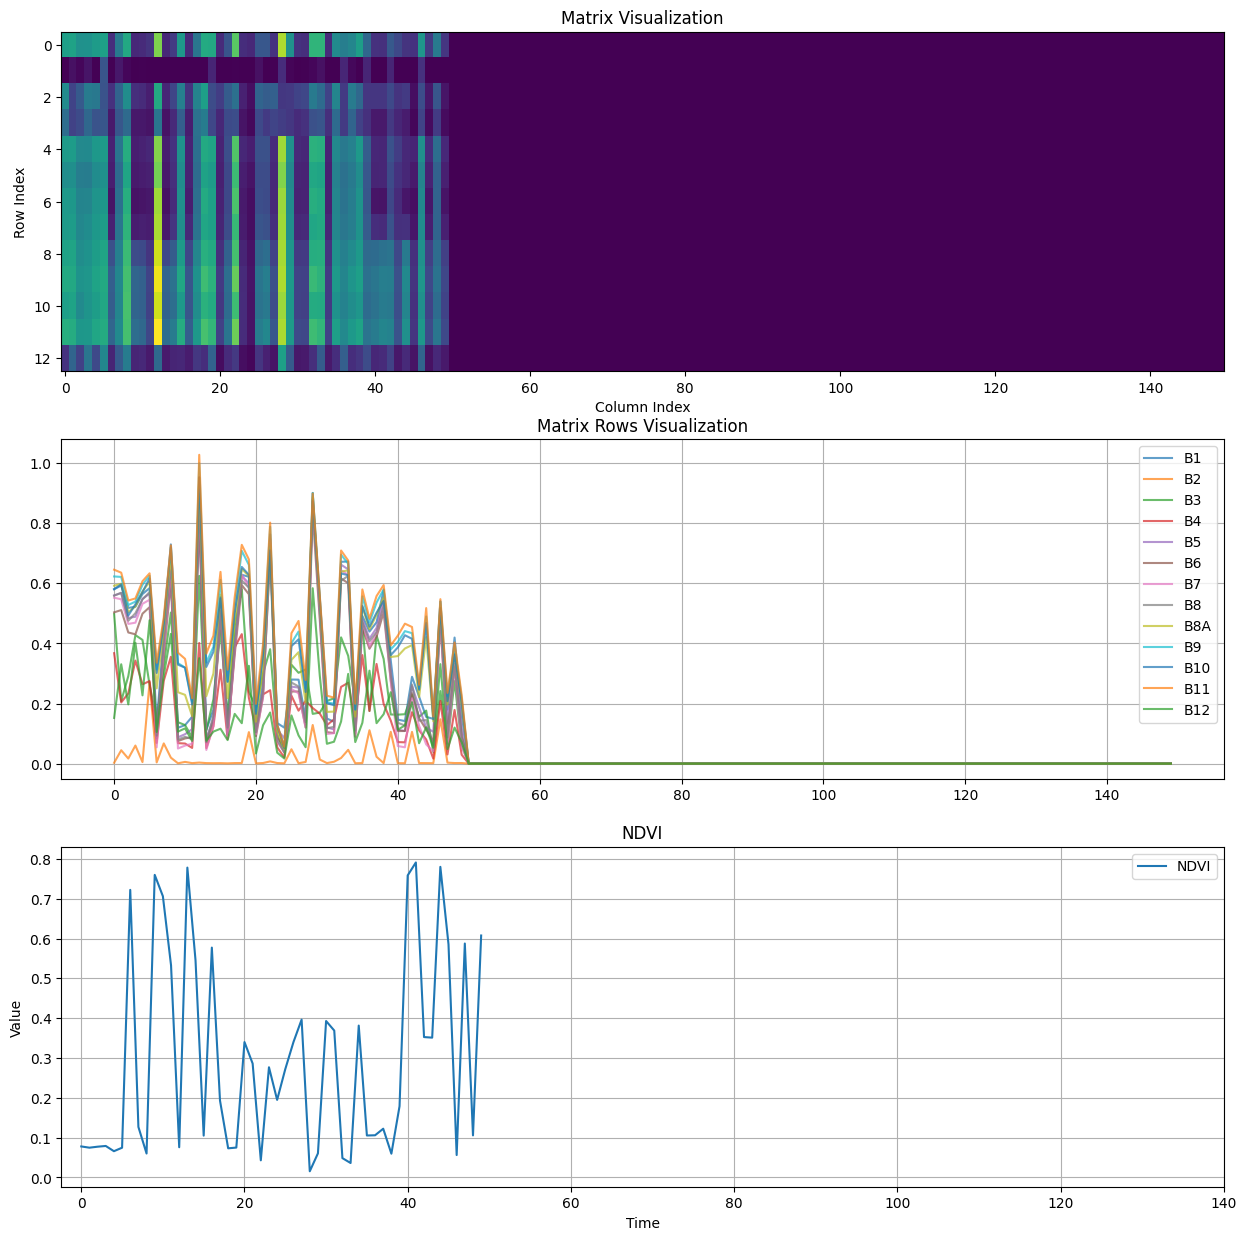

In [40]:
idx = 11495
X,y, id = test_ds[idx]

print("X.shape:", X.shape)
print("y.shape:", y.shape)
print("test_ds.ds.level:", test_ds.ds.level)
print("len(test_ds):", len(test_ds))
print("year:", test_ds.ds.year)
print("index:", test_ds.ds.index)

# plot X
# Convert the tensor to a NumPy array
matrix_np = X.numpy().T

# Plotting the matrix
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
axes[0].imshow(matrix_np, aspect='auto', cmap='viridis') # 'viridis' is a colormap, you can choose any other
axes[0].set_title('Matrix Visualization')
axes[0].set_xlabel('Column Index')
axes[0].set_ylabel('Row Index')

# plot each row of the matrix as a line on the second plot
SELECTED_BANDS = {
    "L1C": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12',
            'QA10', 'QA20', 'QA60', 'doa'],
    "L2A": ['doa', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
            'CLD', 'EDG', 'SAT', ]
}
for i in range(matrix_np.shape[0]):
    axes[1].plot(matrix_np[i], label=f'Row {i}', alpha=0.7)
axes[1].set_title('Matrix Rows Visualization')
axes[1].legend(SELECTED_BANDS["L1C"])
axes[1].grid()

# plot NDVI
plot_NDVI(matrix_np, fig, axes[2])


the dataset consists of 13 bands (`['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']`). The sequence is zero-padded if shorter than `sequencelength=150`.

Let's plot a histogram of the labels to see the distribution of the classes.

Extracting labels from dataset Train


Extracting labels from dataset Validation
Extracting labels from dataset Test


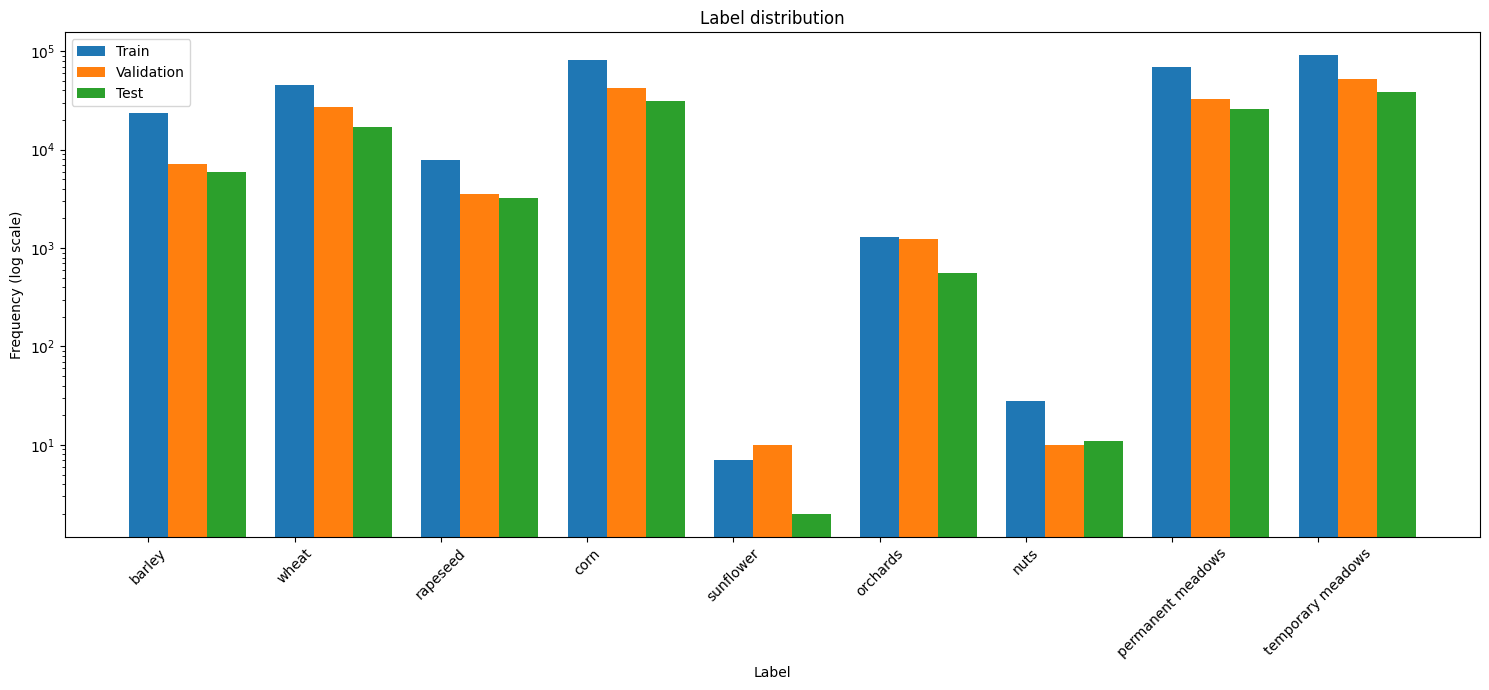

In [4]:
# plot the distribution of the labels, for the train, validation and test sets on the same graph, where the bars are next to each other
fig, ax = plt.subplots(figsize=(15, 7))
datasets = [train_ds, valid_ds, test_ds]
sets_labels = ["Train", "Validation", "Test"]
plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=classes)

In [6]:
# create folder if does not exist
path_folder = "tmp/data_exploration"
os.makedirs(path_folder, exist_ok=True)

In [ ]:
fig.savefig(f"{path_folder}/label_distribution.png")

Explore the length of the sequences (without zero-padding)

In [14]:
def plot_sequence_length_distribution(datasets: list, sets_labels: list, fig, ax, title: str='Sequence length distribution'):
    """
    Plot the distribution of the sequence length of the datasets
    """
    for i, ds in enumerate(datasets):
        sequence_length = ds.get_sequence_lengths()
        ax.hist(sequence_length, bins=100, alpha=0.5, label=sets_labels[i], density=True)
    ax.set_title(title)
    ax.set_xlabel('Sequence length')
    ax.set_ylabel('Frequency (percentage)')   
    ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()]) 
    ax.legend()
    fig.tight_layout()
    return fig, ax

C:\Users\anyam\AppData\Local\Temp\ipykernel_96120\1995764058.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])


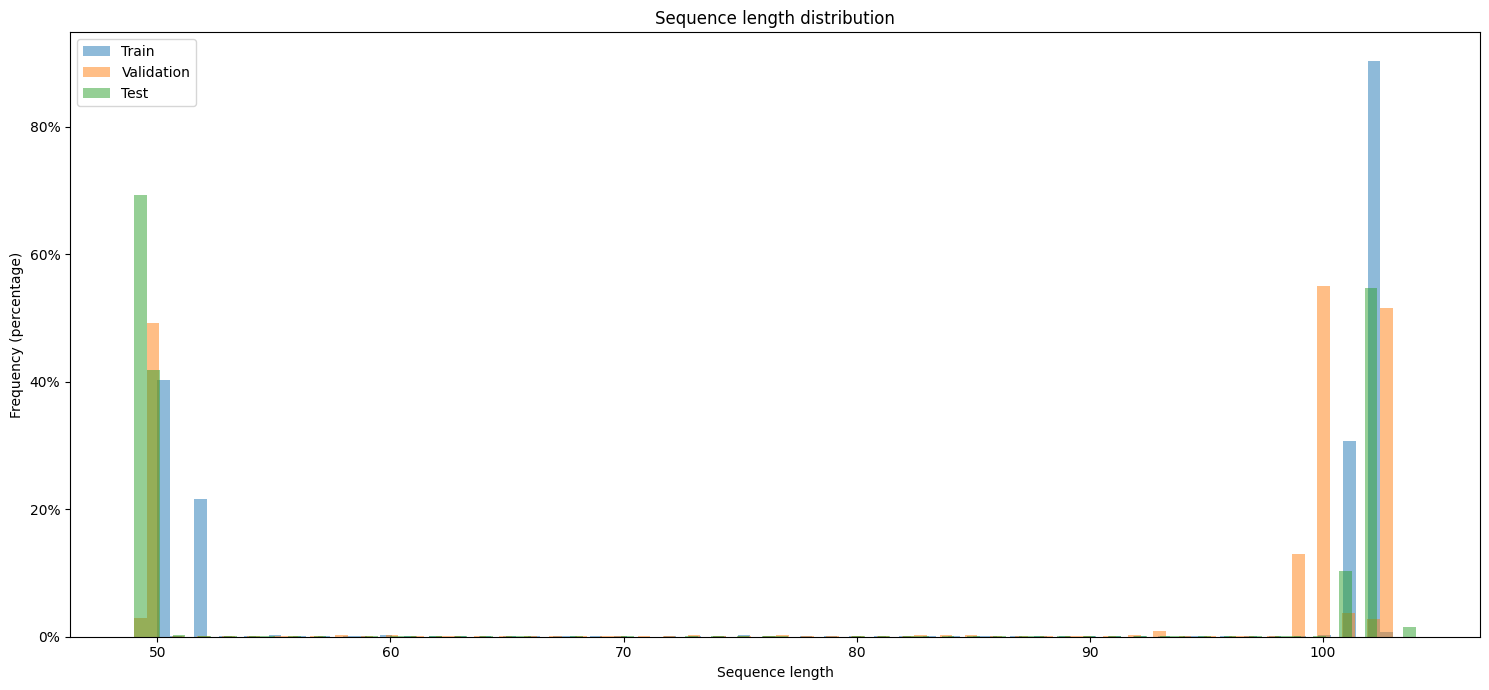

In [15]:
fig, ax = plt.subplots(figsize=(15, 7))
datasets = [train_ds, valid_ds, test_ds]
sets_labels = ["Train", "Validation", "Test"]
fig, ax = plot_sequence_length_distribution(datasets, sets_labels, fig, ax, title='Sequence length distribution')
fig.savefig(f"{path_folder}/sequence_length_distribution.png")

In [30]:
dataloader = DataLoader(test_ds, batch_size=256)
max_iter = 4
for k, batch in enumerate(dataloader):
    if k<max_iter:
        X, y, id = batch
        print(f"at iter k={k}: \nX.shape={X.shape}, \ny.shape={y.shape} \nX={X} \ny={y} \nid={id}\n")
    else: 
        break

at iter k=0: 
X.shape=torch.Size([256, 150, 13]), 
y.shape=torch.Size([256, 150]) 
X=tensor([[[0.5434, 0.0034, 0.4603,  ..., 0.5080, 0.5596, 0.1475],
         [0.3173, 0.0030, 0.2940,  ..., 0.3094, 0.3326, 0.1530],
         [0.6358, 0.0487, 0.2242,  ..., 0.5834, 0.6126, 0.2058],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4327, 0.0018, 0.2969,  ..., 0.3519, 0.3956, 0.0890],
         [0.6407, 0.0453, 0.1654,  ..., 0.6091, 0.6506, 0.2809],
         [0.6276, 0.0375, 0.3304,  ..., 0.6208, 0.6622, 0.2962],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4687, 0.0024, 0.3628,  ..., 0.4261, 0.4705, 0.1042],
         [0.3673, 0.0128, 0.0605,  ...

# Download day of year information for each test field
For Windows: 

In [3]:
import requests

npydoy = 'breizhcrops_frh04_2017_doys.npy'

# Check if the file does not exist and download it
if not os.path.exists(npydoy):
    url = "https://elects.s3.eu-central-1.amazonaws.com/breizhcrops_frh04_2017_doys.npy"
    response = requests.get(url)
    with open(npydoy, 'wb') as f:
        f.write(response.content)

# Load the numpy file
doys_dict = np.load(npydoy, allow_pickle=True)


For linux: 

In [4]:
# npydoy = 'breizhcrops_frh04_2017_doys.npy'
# if not os.path.exists(npydoy):
#     !wget -nc "https://elects.s3.eu-central-1.amazonaws.com/breizhcrops_frh04_2017_doys.npy"

# doys_dict = np.load(npydoy, allow_pickle=True)

## Download model Snapshots

For Windows:

In [5]:
import zipfile

url = "https://elects.s3.eu-central-1.amazonaws.com/elects_models.zip"
zip_path = "elects_models.zip"

# Downloading the file
if not os.path.exists(zip_path):
    response = requests.get(url)
    with open(zip_path, 'wb') as f:
        f.write(response.content)
    print("Downloaded the file")

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")
    print("Extracted the zip file")


Downloaded the file
Extracted the zip file


for Linux

In [ ]:
# !wget -nc "https://elects.s3.eu-central-1.amazonaws.com/elects_models.zip"
# !unzip -n "elects_models.zip"

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


## Define Test and Test+Print Functions

In [8]:

def test(snapshot_path, map_location=device):
    """
    loads model from snapshot and tests it on the test_ds dataset
    returns a dictionary of variables (probability_stopping, predictions_at_t_stop etc)
    """

    with torch.no_grad():
        

        nclasses = 9
        input_dim = 13
        model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(device)
        model.load_state_dict(torch.load(snapshot_path, map_location=map_location))
        model.eval()

        dataloader = DataLoader(test_ds, batch_size=256)
        model.eval()

        stats = []
        losses = []
        slengths = []
        for batch in tqdm(dataloader, leave=False):
            X, y_true, ids = batch
            X, y_true = X.to(device), y_true.to(device)

            seqlengths = (X[:,:,0] != 0).sum(1)
            

            log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
            
            # since data is padded with 0, it is possible that t_stop is after the end of sequence (negative earliness). 
            # we clip the t_stop to the maximum sequencelength here 
            msk = t_stop > seqlengths
            t_stop[msk] = seqlengths[msk]
            
            slengths.append(seqlengths.cpu().detach())
            
            stat = {}
            stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
            stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
            stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["targets"] = y_true.cpu().detach().numpy()
            #print(y_true.cpu().detach().numpy().shape)
            #print(ids.shape)
            stat["ids"] = ids.unsqueeze(1)
            #stat["seqlengths"] = seqlengths.cpu().detach().numpy()

            stats.append(stat)


        # list of dicts to dict of lists
        stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}
        stats["seqlengths"] = Ts = torch.cat(slengths).numpy()

        return stats

def test_print(snapshot_path):
    alpha = float(snapshot_path.split(".pth")[0][-3:])
    stats = test(snapshot_path)
    y_pred = stats["predictions_at_t_stop"][:,0]
    y_true = stats["targets"][:,0]

    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    Ts = stats["seqlengths"]

    t_stop = stats["t_stop"][:,0]

    earliness = 1-(t_stop / Ts)
    t_stop_mean = earliness.mean()
    t_stop_std = earliness.std()

    print(f"$\\alpha = {alpha}$ & {accuracy:.2f} & {kappa:.2f} & {earliness.mean():.2f} $\\pm$ {earliness.std():.2f}")
        #return slengths

## Test Model

In [9]:
stats = test("breizhcropsa0.5.pth")

  0%|          | 0/479 [00:00<?, ?it/s]

# Evaluate Accuracy vs Earliness

models trained via
```
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.0 --snapshot snapshots/breizhcropsa0.0.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.2 --snapshot snapshots/breizhcropsa0.2.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.4 --snapshot snapshots/breizhcropsa0.4.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.6 --snapshot snapshots/breizhcropsa0.6.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.8 --snapshot snapshots/breizhcropsa0.8.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 1.0 --snapshot snapshots/breizhcropsa1.0.pth --batchsize 512

python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.1 --snapshot snapshots/breizhcropsa0.1.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.3 --snapshot snapshots/breizhcropsa0.3.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.5 --snapshot snapshots/breizhcropsa0.5.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.7 --snapshot snapshots/breizhcropsa0.7.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.9 --snapshot snapshots/breizhcropsa0.9.pth --batchsize 512
```

In [10]:
test_print("breizhcropsa0.0.pth")
test_print("breizhcropsa0.2.pth")
test_print("breizhcropsa0.4.pth")
test_print("breizhcropsa0.6.pth")
test_print("breizhcropsa0.8.pth")
test_print("breizhcropsa1.0.pth")

  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.0$ & 0.31 & 0.00 & 1.00 $\pm$ 0.00


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.2$ & 0.80 & 0.74 & 0.73 $\pm$ 0.07


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.4$ & 0.80 & 0.74 & 0.69 $\pm$ 0.07


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.6$ & 0.81 & 0.75 & 0.66 $\pm$ 0.09


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.8$ & 0.80 & 0.74 & 0.60 $\pm$ 0.12


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 1.0$ & 0.81 & 0.75 & 0.00 $\pm$ 0.00


# Analyze Stopping times

## Convert t_stop index to day of year

In [11]:
doy_stop = []
for id, t_stop in zip(stats["ids"][:,0], stats["t_stop"][:,0]):
    doys = doys_dict.flat[0][id]
    doy_stop.append(doys[t_stop-1])
doy_stop = np.array(doy_stop)

## Pring statistics on stopping dates

In [12]:
doy_stop.mean()
mean_doy_stop = doy_stop.mean()
std_doy_stop = doy_stop.std()

def doy2date(doy):
    return datetime.datetime(2017, 1, 1) + datetime.timedelta(int(doy) - 1)

print(doy2date(mean_doy_stop - std_doy_stop))
print(doy2date(mean_doy_stop))
print(doy2date(mean_doy_stop + std_doy_stop))

2017-05-10 00:00:00
2017-06-07 00:00:00
2017-07-06 00:00:00


Saved figure to c:\Users\anyam\Desktop\Master thesis\Code\elects\EDA\tmp\violin.pdf


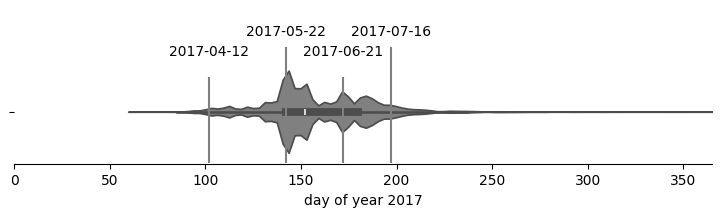

In [14]:
dates = [
    "2017-04-12",
    "2017-05-22",
    "2017-06-21",
    "2017-07-16"
]
doys = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates]

fig, ax = plt.subplots(figsize=(9,2))
seaborn.violinplot(x=doy_stop,orient="h",ax=ax, color="gray")
seaborn.despine(offset=0.5, left=True)
ax.set_xlabel("day of year 2017")
ax.set_ylabel("")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
for d, dt,y in zip(doys, dates,ys):
    ax.axvline(d, ymax=y, color="gray")
    ax.text(d,y,dt,ha="center")
#ax.set_xticks(doys)
#ax.set_xticklabels(dates, rotation=20, ha='right')
tmp_folder_path = os.path.join(os.getcwd(), 'tmp')
if not os.path.exists(tmp_folder_path):
    os.makedirs(tmp_folder_path)
file_path = os.path.join(tmp_folder_path, 'violin.pdf')
fig.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to {file_path}")

## Plot stopping times per class

C:\Users\anyam\AppData\Local\Temp\ipykernel_6492\2078193347.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels_names, fontsize=16)


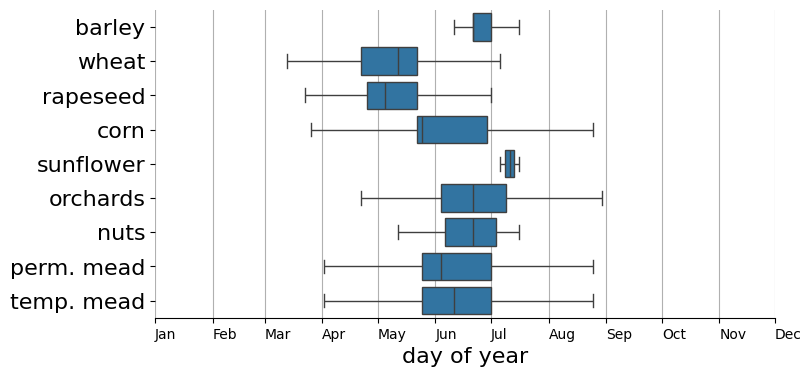

In [15]:
import seaborn
import matplotlib.pyplot as plt

doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]


labels_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'perm. mead', 'temp. mead']

fig, ax = plt.subplots(figsize=(8,4))
seaborn.boxplot(x=doy_stop,y=stats["targets"][:,0],orient="h",ax=ax,showfliers = False)
ax.set_yticklabels(labels_names, fontsize=16)
ax.set_xlabel("day of year", fontsize=16)

ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")

seaborn.despine(left=True)

tmp_folder_path = os.path.join(os.getcwd(), 'tmp/phenology')
if not os.path.exists(tmp_folder_path):
    os.makedirs(tmp_folder_path)
file_path = os.path.join(tmp_folder_path, 'breizhcrops.pdf')
fig.savefig(file_path, transparent=True, bbox_inches="tight")

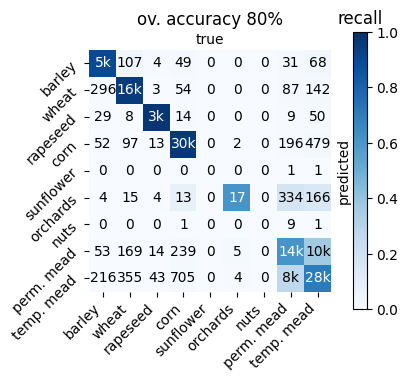

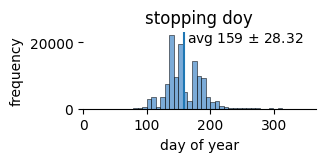

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

labels_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'perm. mead', 'temp. mead']

acier = "#4F8FCC"
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]


cm_norm = confusion_matrix(y_pred, y_true, normalize="true")
cm = confusion_matrix(y_pred, y_true)

fig, ax = plt.subplots(1,1, figsize=(4,4))

plt.rc("axes.spines", top=False, right=False, bottom=False, left=False)

ax.set_xticks(range(len(labels_names)))
ax.set_xticklabels(labels_names, rotation=45, ha="right")

ax.set_yticks(range(len(labels_names)))
ax.set_yticklabels(labels_names, rotation=45, ha="right")

im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm_norm[i,j] > 0.5 else "black"
        txt = str(cm[i,j])
        txt = txt[:-3] + "k" if len(txt) > 3 else txt
        ax.text(i,j, txt, ha="center", va="center", color=color)
        
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.9, pad = 0.07)
cbar.ax.set_title('recall')

ax.yaxis.set_label_position("right")
ax.set_ylabel("predicted")
ax.xaxis.set_label_position("top")
ax.set_xlabel("true")

accuracy = accuracy_score(y_pred, y_true)
ax.set_title(f"ov. accuracy {accuracy*100:.0f}%")   
tmp_folder_path = os.path.join(os.getcwd(), 'tmp')
if not os.path.exists(tmp_folder_path):
    os.makedirs(tmp_folder_path)
file_path = os.path.join(tmp_folder_path, 'france_confmat.pdf')

fig.savefig(file_path,dpi=300,bbox_inches='tight')
fig, ax = plt.subplots(1,1, figsize=(3,1))
        
seaborn.histplot(x=doy_stop,ax=ax, color=acier, binwidth=7)
seaborn.despine(offset=0, left=True)
ax.set_xlabel("day of year")
ax.set_ylabel("frequency")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
#ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
#ax.set_xticks(doys)
ax.set_title(f"stopping doy")
ax.axvline(doy_stop.mean())
ax.text(doy_stop.mean()+5,20000, f"avg {doy_stop.mean():.0f} $\pm$ {doy_stop.std():.2f}", color="black")
#ax.set_xticklabels(dates, rotation=20, ha='right')

file_path = os.path.join(tmp_folder_path, 'france_violin.pdf')
fig.savefig(file_path,dpi=300,bbox_inches='tight')

## Check which class differences are statistically significant (pvalue < 0.05)

## Check which class differences are statistically significant (pvalue < 0.05)

In [18]:
from itertools import product

rapeseed_stops = doy_stop[stats["targets"][:,0] == labels_names.index("rapeseed")]
rapeseed_stops.mean(), rapeseed_stops.std(), np.median(rapeseed_stops), datetime.datetime(2017,1,1) + datetime.timedelta(days=125.0)

from itertools import product

barley_stops = doy_stop[stats["targets"][:,0] == labels_names.index("barley")]
barley_stops.mean(), barley_stops.std(), np.median(barley_stops), datetime.datetime(2017,1,1) + datetime.timedelta(days=int(barley_stops.mean()))

from scipy import stats as st

def print_statistic(lab1, lab2):
    A = doy_stop[stats["targets"][:,0] == labels_names.index(lab1)]
    B = doy_stop[stats["targets"][:,0] == labels_names.index(lab2)]

    test = st.ks_2samp(A, B)
    print(f"{lab1} vs {lab2}: KS-distance {test.statistic:.2f}, pvalue {test.pvalue:.2f}")
    
for lab1, lab2 in product(labels_names,labels_names):
    print_statistic(lab1, lab2)

barley vs barley: KS-distance 0.00, pvalue 1.00
barley vs wheat: KS-distance 0.83, pvalue 0.00
barley vs rapeseed: KS-distance 0.80, pvalue 0.00
barley vs corn: KS-distance 0.60, pvalue 0.00
barley vs sunflower: KS-distance 0.78, pvalue 0.10
barley vs orchards: KS-distance 0.22, pvalue 0.00
barley vs nuts: KS-distance 0.32, pvalue 0.16
barley vs perm. mead: KS-distance 0.46, pvalue 0.00
barley vs temp. mead: KS-distance 0.46, pvalue 0.00
wheat vs barley: KS-distance 0.83, pvalue 0.00
wheat vs wheat: KS-distance 0.00, pvalue 1.00
wheat vs rapeseed: KS-distance 0.12, pvalue 0.00
wheat vs corn: KS-distance 0.46, pvalue 0.00
wheat vs sunflower: KS-distance 0.91, pvalue 0.02
wheat vs orchards: KS-distance 0.71, pvalue 0.00
wheat vs nuts: KS-distance 0.67, pvalue 0.00
wheat vs perm. mead: KS-distance 0.63, pvalue 0.00
wheat vs temp. mead: KS-distance 0.59, pvalue 0.00
rapeseed vs barley: KS-distance 0.80, pvalue 0.00
rapeseed vs wheat: KS-distance 0.12, pvalue 0.00
rapeseed vs rapeseed: KS-d

## Plot Correct vs Incorrect Stopping Times

C:\Users\anyam\AppData\Local\Temp\ipykernel_6492\1147907340.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.violinplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
C:\Users\anyam\AppData\Local\Temp\ipykernel_6492\1147907340.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["incorrect", "correct"])


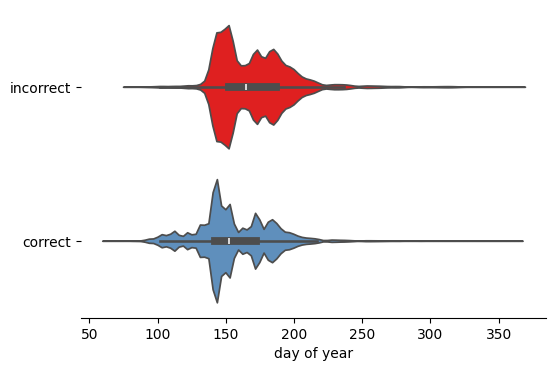

In [19]:
correct = stats["predictions_at_t_stop"][:,0] == stats["targets"][:,0]

canard = "#007480"
grosseile = "#b51f1f"
rouge = "#FF0000"
leman = "#00A79F"
acier = "#4F8FCC"

fig, ax = plt.subplots(figsize=(6,4))
seaborn.violinplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
ax.set_yticklabels(["incorrect", "correct"])
seaborn.despine(left=True)
ax.set_xlabel("day of year")
file_path = os.path.join(tmp_folder_path, 'correctwrongbzhviolin.pdf')
fig.savefig(file_path)

C:\Users\anyam\AppData\Local\Temp\ipykernel_6492\2642096591.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.boxplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
C:\Users\anyam\AppData\Local\Temp\ipykernel_6492\2642096591.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["incorrect", "correct"])


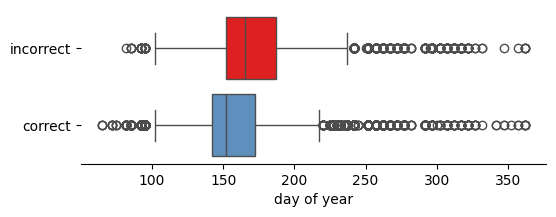

In [20]:
fig, ax = plt.subplots(figsize=(6,2))
seaborn.boxplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
ax.set_yticklabels(["incorrect", "correct"])
seaborn.despine(left=True)
ax.set_xlabel("day of year")
file_path = os.path.join(tmp_folder_path, 'correctwrongbzhboxplot.pdf')
fig.savefig(file_path, bbox_inches="tight")

In [21]:
mean_correct = doy_stop[correct].mean()
mean_wrong = doy_stop[~correct].mean()
std_correct = doy_stop[correct].std()
std_wrong = doy_stop[~correct].std()

Ts = stats["seqlengths"]
t_stop = stats["t_stop"][:,0]
earliness = 1-(t_stop / Ts)

from scipy import stats as st
st.ks_2samp(doy_stop[correct], doy_stop[~correct])

KstestResult(statistic=0.24624547207476863, pvalue=0.0, statistic_location=142, statistic_sign=1)

In [22]:
print(datetime.date(2017, 1, 1) + datetime.timedelta(int(mean_correct) - 1))
print(datetime.date(2017, 1, 1) + datetime.timedelta(int(mean_wrong) - 1))

2017-06-05
2017-06-18


## Plot class and stopping probability

In [24]:
stats = test("breizhcropsa0.5.pth")

nclasses = 9
input_dim = 13
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(device)
model.load_state_dict(torch.load("breizhcropsa0.5.pth", map_location=device))
model.eval()

def ndvi(X):
    BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
            'B8A', 'B9']
    red = X[BANDS.index("B4")]
    nir = X[BANDS.index("B8A")]
    return (nir-red)/(nir+red)

dates_of_interest = [
    "2017-01-25",
    "2017-04-22",
    "2017-06-01",
    "2017-07-09",
    "2017-08-25"
] 



doys_of_interest = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates_of_interest]

def add_doys_lines(ax):
    for d in doys_of_interest:
        ax.axvline(d)
        
def plot(doys, class_probabilities, stop_probabilities):
    fig, axs = plt.subplots(2,1, figsize=(6,4), sharex=True)
    seaborn.despine()
    ax = axs[0]
    ax.plot(doys, class_probabilities)
    #ax.set_xlabel("day of year")
    ax.set_ylabel("class score")
    add_doys_lines(ax)

    ax = axs[1]
    ax.plot(doys, stop_probabilities)
    ax.set_xlabel("day of year")
    ax.set_ylabel("stopping probability")
    add_doys_lines(ax)
    
def plot_id(id):
    idx = list(stats["ids"][:,0]).index(id)

    X,y, id = test_ds[idx]
    doys = doys_dict.flat[0][id]

    t_stop = stats["t_stop"][idx,0]
    doy_stop = doys[t_stop]
    date_stop = datetime.datetime(2017,1,1) + datetime.timedelta(days=int(doy_stop-1))

    msk = X[:,0]>0
    X = X[msk]
    X = X.unsqueeze(0).to(device)
    log_class_probabilities, probability_stopping = model(X)

    class_probabilities = log_class_probabilities[0].cpu().detach().exp()
    stop_probabilities = probability_stopping[0].cpu().detach()

    plot(doys, class_probabilities, stop_probabilities)


    print(id)

    y = stats["targets"][idx,0]
    print(f"class {y}")

    pred = stats["predictions_at_t_stop"][idx,0]
    print(f"pred {pred}")

    print(t_stop, doy_stop, date_stop)

  0%|          | 0/479 [00:00<?, ?it/s]

6052609
class 2
pred 2
22 115 2017-04-25 00:00:00
6052610
class 3
pred 3
29 152 2017-06-01 00:00:00
6047524
class 8
pred 8
29 152 2017-06-01 00:00:00
6047526
class 3
pred 3
40 192 2017-07-11 00:00:00


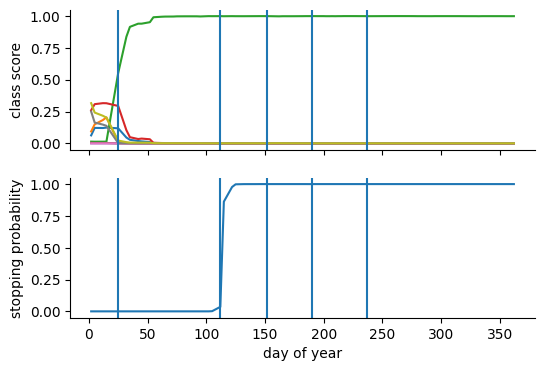

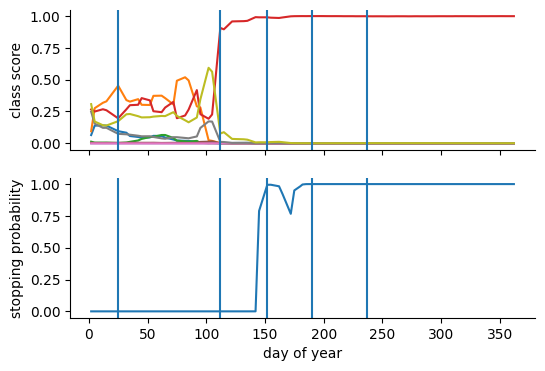

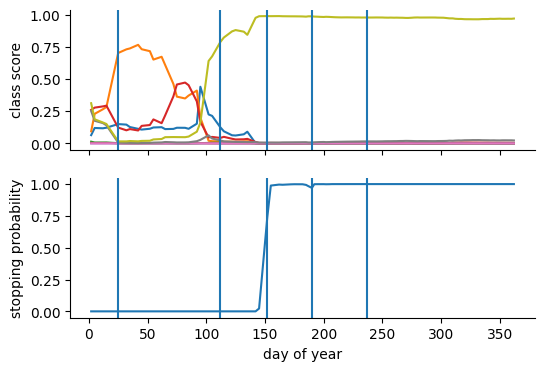

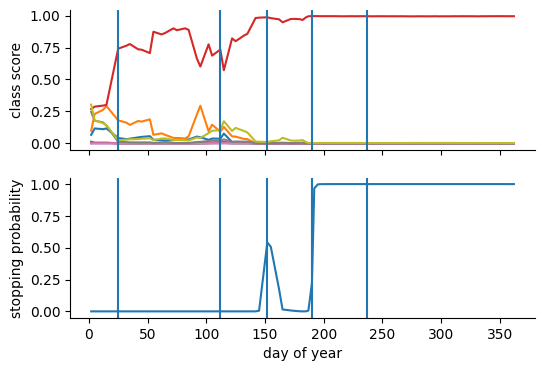

In [25]:
plot_id(6052609)
plot_id(6052610)
plot_id(6047524)
plot_id(6047526)

## Plot Two Qualitative Samples

FileNotFoundError: [Errno 2] No such file or directory: '/tmp\\input.pdf'

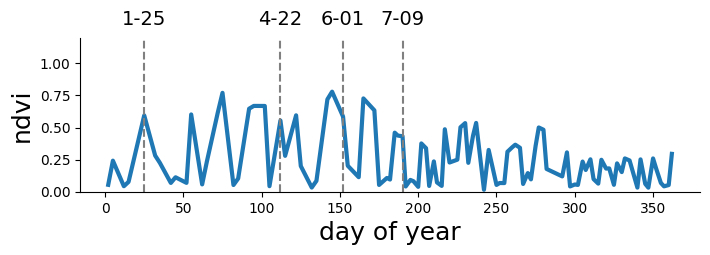

In [26]:
id = 6052609


dates_of_interest = [
    "2017-01-25",
    "2017-04-22",
    "2017-06-01",
    "2017-07-09"
] 

ymaxs = [1.3,1.3,1.3,1.3]
ymins = [0,0,0,0]
doys_of_interest = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates_of_interest]

def add_doys_lines(ax):
    for d, date, ymax, ymin in zip(doys_of_interest, dates_of_interest, ymaxs, ymins):
        ax.axvline(d, color="gray", ymin=ymin, ymax=ymax, linestyle="--")
        ax.text(d, ymax,date.replace("2017-0",""), ha="center", fontsize=14)

labs = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'perm. mead', 'temp. mead']
        
    
figsize=(8,2)
store_path = "/tmp"

idx = list(stats["ids"][:,0]).index(id)

X,y, id = test_ds[idx]
doys = doys_dict.flat[0][id]

t_stop = stats["t_stop"][idx,0]
doy_stop = doys[t_stop]
date_stop = datetime.datetime(2017,1,1) + datetime.timedelta(days=int(doy_stop-1))

msk = X[:,0]>0
X = X[msk]
X = X.unsqueeze(0).to(device)
log_class_probabilities, probability_stopping = model(X)

fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, ndvi(X[0,:,:].T).cpu(), linewidth=3)
ax.set_ylabel("ndvi", fontsize=18)
ax.set_xlabel("day of year", fontsize=18)
seaborn.despine()
ax.set_ylim(0,1.2)
add_doys_lines(ax)
fig.savefig(os.path.join(store_path,"input.pdf"))


fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, log_class_probabilities[0].cpu().detach().exp(), linewidth=3)
ax.set_xlabel("day of year", fontsize=18)
ax.set_ylabel("class score", fontsize=18)
add_doys_lines(ax)
seaborn.despine()
ax.set_ylim(0,1.2)
ax.set_ylim(0,1.2)
#ax.legend(labs, ncol=5, bbox_to_anchor=(0, 0, 1, -0.3))
fig.savefig(os.path.join(store_path,"proba_class.pdf"), bbox_inches="tight",transparent=True)

fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, probability_stopping[0].cpu().detach(), linewidth=3)
ax.set_xlabel("day of year", fontsize=18)
ax.set_ylabel("stop prob.", fontsize=18)
add_doys_lines(ax)
ax.set_ylim(0,1.2)
seaborn.despine()
fig.savefig(os.path.join(store_path,"proba_stop.pdf"), bbox_inches="tight",transparent=True)
print(id)

y = stats["targets"][idx,0]
print(f"class {y}")

pred = stats["predictions_at_t_stop"][idx,0]
print(f"pred {pred}")

print(t_stop, doy_stop, date_stop)


6047524
class 8
pred 8
29 152 2017-06-01 00:00:00


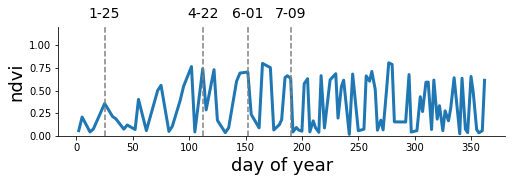

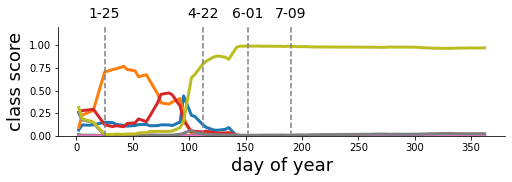

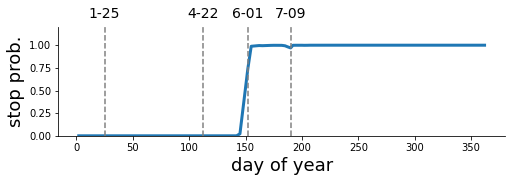

In [ ]:
id = 6047524

        
figsize=(8,2)
    
import os
store_path = tmp_folder_path

idx = list(stats["ids"][:,0]).index(id)

X,y, id = test_ds[idx]
doys = doys_dict.flat[0][id]

t_stop = stats["t_stop"][idx,0]
doy_stop = doys[t_stop]
date_stop = datetime.datetime(2017,1,1) + datetime.timedelta(days=int(doy_stop-1))

msk = X[:,0]>0
X = X[msk]
X = X.unsqueeze(0).to(device)
log_class_probabilities, probability_stopping = model(X)

fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, ndvi(X[0,:,:].T).cpu(), linewidth=3)
ax.set_ylabel("ndvi", fontsize=18)
ax.set_xlabel("day of year", fontsize=18)
seaborn.despine()
ax.set_ylim(0,1.2)
add_doys_lines(ax)
fig.savefig(os.path.join(store_path,"input2.pdf"))


fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, log_class_probabilities[0].cpu().detach().exp(), linewidth=3)
ax.set_xlabel("day of year", fontsize=18)
ax.set_ylabel("class score", fontsize=18)
add_doys_lines(ax)
seaborn.despine()
ax.set_ylim(0,1.2)
ax.set_ylim(0,1.2)
#ax.legend(labs, ncol=5, bbox_to_anchor=(0, 0, 1, -0.3))
fig.savefig(os.path.join(store_path,"proba_class2.pdf"), bbox_inches="tight",transparent=True)

fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, probability_stopping[0].cpu().detach(), linewidth=3)
ax.set_xlabel("day of year", fontsize=18)
ax.set_ylabel("stop prob.", fontsize=18)
add_doys_lines(ax)
ax.set_ylim(0,1.2)
seaborn.despine()
fig.savefig(os.path.join(store_path,"proba_stop2.pdf"), bbox_inches="tight",transparent=True)
print(id)

y = stats["targets"][idx,0]
print(f"class {y}")

pred = stats["predictions_at_t_stop"][idx,0]
print(f"pred {pred}")

print(t_stop, doy_stop, date_stop)


## Qualitative Plots in a window

In [ ]:
import geopandas as gpd
import breizhcrops as bzh
from shapely.geometry import Polygon

coords = [[-2.4051745919139944, 47.55745967351906],
          [-2.4051745919139944, 47.53283666582435],
          [-2.365263321772393, 47.53283666582435],
          [-2.365263321772393, 47.55745967351906]]

polygon_geom = Polygon(coords)


polygon = gpd.GeoDataFrame(index=[0], crs=4326, geometry=[polygon_geom])    

ds = bzh.BreizhCrops("frh04", root=data_root, transform=lambda x: x, preload_ram=False, recompile_h5_from_csv=False, year=2017)
gdf = ds.geodataframe().to_crs(4326)
  

In [ ]:
fields = gdf.sjoin(polygon, how="inner")

<AxesSubplot:>

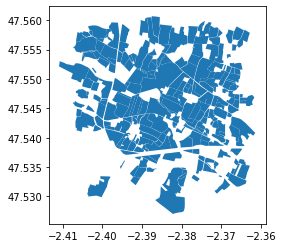

In [ ]:
fields.plot()

In [ ]:
# select subset of stats
msk = np.isin(stats["ids"][:,0], fields.id.values)
msk.sum()

sel_stats = {}
for k,v in stats.items():
    sel_stats[k] = v[msk]
    
doy_stop = []
for id, t_stop in zip(sel_stats["ids"][:,0], sel_stats["t_stop"][:,0]):
    doys = doys_dict.flat[0][id]
    doy_stop.append(doys[t_stop-1])
doy_stop = np.array(doy_stop)
sel_stats["doy_stop"] = doy_stop

summary = pd.DataFrame(
    [sel_stats["ids"][:,0], sel_stats["doy_stop"], sel_stats["predictions_at_t_stop"][:,0], sel_stats["targets"][:,0]], 
                       index=["id","doy_stop","predictions_at_t_stop","targets"]).T.set_index("id")

In [ ]:
annot_fields = fields.set_index("id").join(summary)
annot_fields["correct"] = annot_fields["targets"] == annot_fields["predictions_at_t_stop"]
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

canard = "#007480"
grosseile = "#b51f1f"
rouge = "#FF0000"
leman = "#00A79F"
acier = "#4F8FCC"


newcmp = ListedColormap([grosseile, acier])
stopped_cmap = ListedColormap(["white","black"])


classes_cmap = ListedColormap(["#3274A1", "#E1812C", "#3A913A", "#C03D3E", "#886BA3", "#845B53", "#D584BD", "#7F7F7F", "#A9AA35"])

storepath = "/tmp/maps/"
os.makedirs(storepath, exist_ok=True)

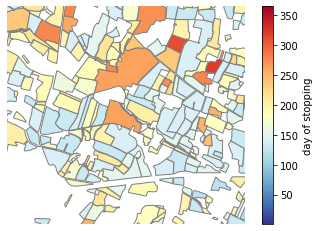

In [ ]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()

tifroot = "/home/marc/projects/re-elects/images/frh04"

xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")
annot_fields.plot(column="doy_stop", ax=ax, cmap="RdYlBu_r", vmin=1, 
                  vmax=365, legend=True, edgecolor="gray", legend_kwds={'label': 'day of stopping', "orientation": "vertical"})
fig.savefig(os.path.join(storepath,"doy_stop.pdf"), bbox_inches="tight",transparent=True)
#cx.add_basemap(ax, crs=annot_fields.crs.to_string(),source=os.path.join(tifroot, "20170412.tif"))

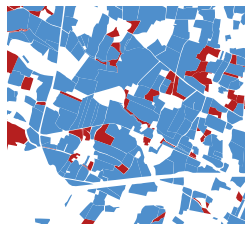

In [ ]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()


xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="correct", ax=ax, cmap=newcmp)
fig.savefig(os.path.join(storepath,"correct.pdf"), bbox_inches="tight",transparent=True)
#cx.add_basemap(ax, crs=annot_fields.crs.to_string(),source=os.path.join(tifroot, "20170412.tif"))

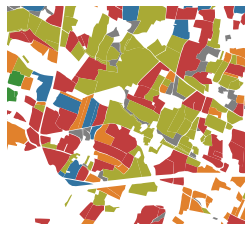

In [ ]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()

xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="targets", ax=ax, cmap=classes_cmap)
fig.savefig(os.path.join(storepath,"targets.pdf"), bbox_inches="tight",transparent=True)

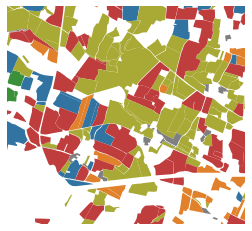

In [ ]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()


xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="predictions_at_t_stop", ax=ax, cmap=classes_cmap)
fig.savefig(os.path.join(storepath,"predictions.pdf"), bbox_inches="tight",transparent=True)

In [ ]:
dates_of_interest = ["2017-04-12","2017-05-22","2017-06-21","2017-07-16"]
doys_of_interest = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates_of_interest]

## Qualitative Samples at different times

date 2017-04-12: accuracy all 0.54
date 2017-04-12: accuracy stopped nan


/home/marc/anaconda3/envs/elects/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


date 2017-05-22: accuracy all 0.74
date 2017-05-22: accuracy stopped 1.00
date 2017-06-21: accuracy all 0.75
date 2017-06-21: accuracy stopped 0.88
date 2017-07-16: accuracy all 0.74
date 2017-07-16: accuracy stopped 0.79


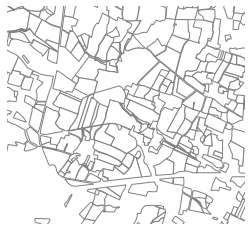

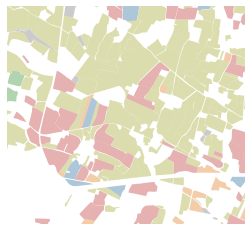

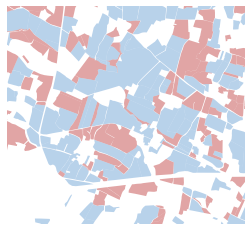

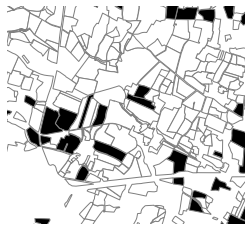

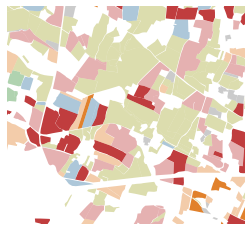

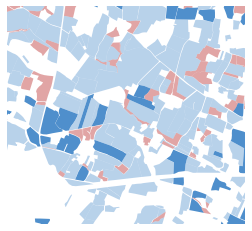

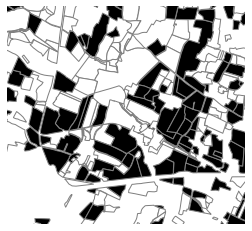

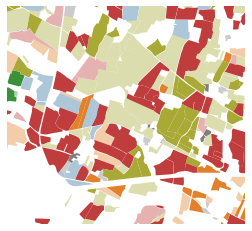

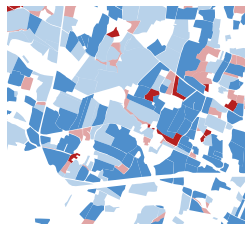

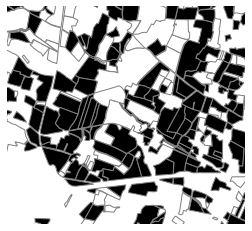

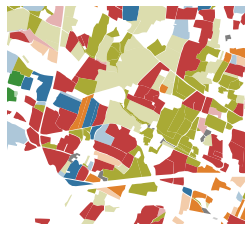

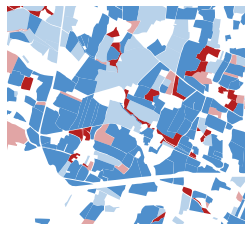

In [ ]:
alpha=0.4

for doy, date in zip(doys_of_interest, dates_of_interest):
    annot_fields["stopped_before_doy"] = annot_fields["doy_stop"] < doy
    
    t_stop = np.argwhere(doys==doy)[0]
    annot_fields["prediction_at_doy"] = sel_stats["class_probabilities"].argmax(2)[:,t_stop][:,0]
    
    annot_fields["correct_at_doy"] = annot_fields["prediction_at_doy"] == annot_fields["targets"]
    
    overall_accuracy = annot_fields["correct_at_doy"].mean()
    print(f"date {date}: accuracy all {overall_accuracy:.2f}")
    
    
    overall_accuracy_stopped = annot_fields["correct_at_doy"].loc[annot_fields["stopped_before_doy"]].mean()
    print(f"date {date}: accuracy stopped {overall_accuracy_stopped:.2f}")
    
    
    

    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    annot_fields.plot(column="stopped_before_doy", ax=ax, cmap=stopped_cmap,  edgecolor='gray')
    fig.savefig(os.path.join(storepath,f"stopped_at_date_{date}.pdf"), bbox_inches="tight",transparent=True)
    
    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    if annot_fields["stopped_before_doy"].sum() > 0:
        annot_fields.loc[annot_fields["stopped_before_doy"]].plot(column="prediction_at_doy", 
                                                                  ax=ax, cmap=classes_cmap, vmin=0, vmax=8)
        annot_fields.loc[~annot_fields["stopped_before_doy"]].plot(column="prediction_at_doy", 
                                                                  ax=ax, cmap=classes_cmap, alpha=alpha, vmin=0, vmax=8)
    else:
        annot_fields.plot(column="prediction_at_doy", ax=ax, cmap=classes_cmap, alpha=alpha, vmin=0, vmax=8)
        
    fig.savefig(os.path.join(storepath,f"prediction_at_date_{date}.pdf"), bbox_inches="tight",transparent=True)
    
    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    
    if annot_fields["correct_at_doy"].sum() > 0:
        annot_fields.loc[annot_fields["stopped_before_doy"]].plot(column="correct_at_doy", 
                                                                  ax=ax, cmap=newcmp, vmin=0, vmax=1)
        annot_fields.loc[~annot_fields["stopped_before_doy"]].plot(column="correct_at_doy", 
                                                                  ax=ax, cmap=newcmp, alpha=alpha, vmin=0, vmax=1)
    else:
        annot_fields.plot(column="correct_at_doy", ax=ax, cmap=newcmp, alpha=alpha, vmin=0, vmax=1)
        
    fig.savefig(os.path.join(storepath,f"correct_at_doy_{date}.pdf"), bbox_inches="tight",transparent=True)

In [ ]:
predictions = stats["predictions_at_t_stop"][:,0]
targets = stats["targets"][:,0]

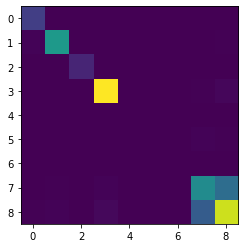

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score

plt.imshow(confusion_matrix(targets, predictions))

In [ ]:
recalls = recall_score(targets, predictions, average=None)

In [ ]:
for cl, acc in zip(classes, recalls):
    print(f"{cl}: {acc:.2f}")

barley: 0.96
wheat: 0.97
rapeseed: 0.97
corn: 0.97
sunflower: 0.00
orchards: 0.03
nuts: 0.00
permanent meadows: 0.56
temporary meadows: 0.73
